# Setup Libraries and Enviroment Variables

In [2]:
# Load necessary libraries and Account IDs
import boto3
import sagemaker
import pandas as pd

sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
account_id = boto3.client("sts").get_caller_identity().get("Account")

sm = boto3.Session().client(service_name="sagemaker", region_name=region)

database_name = "insta_db"

from pyathena import connect

In [3]:
# Set S3 staging directory -- this is a temporary directory used for Athena queries
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)

In [4]:
# Make Connections
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

# Data Processing for Logistic Regression Model

In [ ]:
# SQL statement
statement = """
DROP TABLE IF EXISTS insta_db.final_parquet
"""
import pandas as pd

pd.read_sql(statement, conn)


In [ ]:
# SQL statement
statement = """
CREATE TABLE IF NOT EXISTS insta_db.final_parquet
WITH (format = 'PARQUET', \
        external_location = 's3://{}/parquet/final_parquet') AS 
with orders as(
select *
, sum(coalesce(days_since_prior_order,0)) over (partition by user_id order by order_number asc) as days
FROM insta_db.orders_parquet
), products as (
select t.*, p.product_name, d.department, a.aisle
from (
SELECT *
FROM insta_db.order_products_prior_parquet
) t
left join insta_db.products_parquet p
on t.product_id = p.product_id
left join insta_db.departments_parquet d
on p.department_id = d.department_id
left join insta_db.aisles_parquet a
on p.aisle_id = a.aisle_id
)
select p.reordered
, p.product_name
, p.department
, p.aisle
, coalesce( days - lag(days) over (partition by o.user_id, p.product_id order by o.order_number) , 0) as days_since_previous_order
from products p
join orders o
on p.order_id = o.order_id
order by p.product_id,
o.order_number ASC
""".format(
    bucket
)

import pandas as pd

pd.read_sql(statement, conn)


# Model Data

In [5]:
# SQL statement
statement = """
select *
, pow(days_since_previous_order,2) as days_2
, pow(days_since_previous_order,3) as days_3
, pow(days_since_previous_order,4) as days_4
, pow(days_since_previous_order,5) as days_5
, pow(days_since_previous_order,6) as days_6
, pow(days_since_previous_order,7) as days_7
, pow(days_since_previous_order,8) as days_8
from insta_db.final_parquet limit 200000
"""

import pandas as pd

df = pd.read_sql(statement, conn)
df.head(5)

,reordered,product_name,department,aisle,days_since_previous_order,days_2,days_3,days_4,days_5,days_6,days_7,days_8
0,1,Sparkling Orange Juice & Prickly Pear Beverage,beverages,water seltzer sparkling water,14.0,196.0,2744.0,38416.0,537824.0,7.529536e+06,1.054135e+08,1.475789e+09
1,1,Sparkling Orange Juice & Prickly Pear Beverage,beverages,water seltzer sparkling water,10.0,100.0,1000.0,10000.0,100000.0,1.000000e+06,1.000000e+07,1.000000e+08
2,1,Sparkling Orange Juice & Prickly Pear Beverage,beverages,water seltzer sparkling water,59.0,3481.0,205379.0,12117361.0,714924299.0,4.218053e+10,2.488651e+12,1.468304e+14
3,1,Sparkling Orange Juice & Prickly Pear Beverage,beverages,water seltzer sparkling water,30.0,900.0,27000.0,810000.0,24300000.0,7.290000e+08,2.187000e+10,6.561000e+11
4,1,Sparkling Orange Juice & Prickly Pear Beverage,beverages,water seltzer sparkling water,10.0,100.0,1000.0,10000.0,100000.0,1.000000e+06,1.000000e+07,1.000000e+08


In [6]:
# Let's Create Dummies

# product = pd.get_dummies(df['product_name'],drop_first=True)
department = pd.get_dummies(df['department'],drop_first=True)
aisle = pd.get_dummies(df['aisle'],drop_first=True)

# Concatenate new columns with dummies to df
df = pd.concat([df, department, aisle], axis =1)

In [7]:
print(df.columns)

Index(['reordered', 'product_name', 'department', 'aisle',
       'days_since_previous_order', 'days_2', 'days_3', 'days_4', 'days_5',
       'days_6',
       ...
       'spices seasonings', 'spirits', 'spreads', 'tea',
       'tofu meat alternatives', 'trail mix snack mix', 'vitamins supplements',
       'water seltzer sparkling water', 'white wines', 'yogurt'],
      dtype='object', length=147)


# Model Logistic Regression / Propensisty Model

In [8]:
# Get Libraries
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

from matplotlib import pyplot

[Text(0.5, 1.0, 'Number of Repurchased Products')]

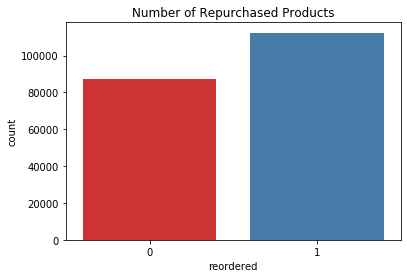

In [9]:
sns.countplot(x='reordered', data = df , palette = 'Set1').set(title= 'Number of Repurchased Products')

In [10]:
Y = pd.DataFrame(df['reordered'])
Y = Y.apply(pd.to_numeric)

X = df.drop(['reordered', 'product_name', 'department', 'aisle', 'days_6','days_7','days_8'], axis = 1)
X = X.apply(pd.to_numeric)

In [11]:
# Test Train Split Data 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

In [12]:
# Build the Model
logmodel = LogisticRegression(class_weight = 'balanced', max_iter =10000000)
logmodel.fit(X_train, y_train.values.ravel())    
predictions_log= logmodel.predict(X_test)

In [13]:
# Model Evaluation
print(classification_report(y_test,predictions_log))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     26256
           1       1.00      0.99      0.99     33744

    accuracy                           0.99     60000
   macro avg       0.99      0.99      0.99     60000
weighted avg       0.99      0.99      0.99     60000



We can see that our model has a 97% precision rate for not repurchased and a 100% precision rate for repurchase. 

In [14]:
# Feature Importance
importance = logmodel.coef_.flatten()

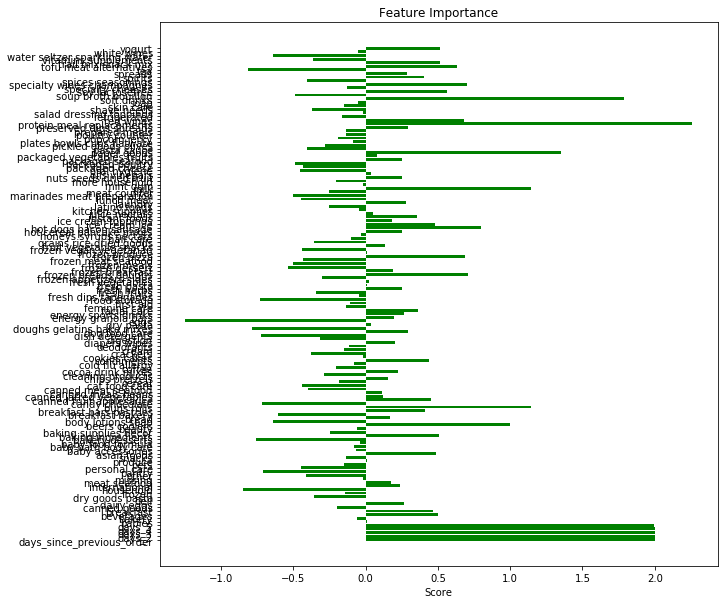

In [15]:
# Barplot of features

pyplot.rcParams["figure.figsize"]=(10,10)
pyplot.barh(X.columns,importance, color = 'g')
pyplot.title("Feature Importance")
pyplot.xlabel("Score")
pyplot.show()


# What will we do with this model

With this propensisty model.  We will use it to score customer product purchase history to determine which of thier past purchases have the highest propensity to be repurchased. This sorted list of possible repurchase products will be used for remarketing purposes for the customer across the website, in emails, and on direct mail flyers. The hopes is to bring the customer back and in so doing, we get the opportunity to cross sell the customer on our other products. 